In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/thesis

Mounted at /content/drive
/content/drive/MyDrive/thesis


In [ ]:
#!pip install torch_dct

In [ ]:
import cv2
import numpy as np
import cupy as cp
import os
import time
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Data Pre-Processing:

In [ ]:
wm_val0 = torch.load('/content/drive/MyDrive/thesis/watermark_tensors/watermark_val_tensor', weights_only=True)/255

In [ ]:
#wm_val = torch.cat((wm_val0, wm_val0[0:101]), dim=0)
#print(wm_val.shape)
wm_val = wm_val0[:,:,210:330,480-106:480+107]
wm_val.shape

torch.Size([300, 1, 120, 213])

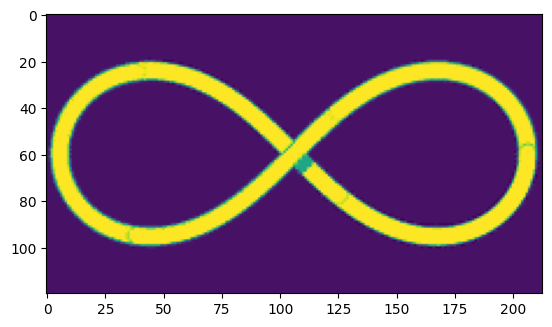

In [ ]:
plt.imshow(wm_val[0][0])

Model Building and Design:

Building Loop:

In [ ]:
class DeclareDataset(Dataset):

    def __init__(self, video_frames, watermark_frames, conv_video=None):
        self.video = video_frames
        self.watermark = watermark_frames
        self.conv = conv_video

    def __getitem__(self, idx):
        watermark = self.watermark[idx]
        video = self.video[idx]

        if self.conv is not None:
          conv = self.conv[idx]
          return video, watermark, conv

        return video, watermark

    def __len__(self):
        return len(self.video)

In [ ]:
def graph_loss(file_name, save_fig=False):
    training_loss1 = pickle.load(open(os.path.join(out,"training_loss1.pkl"),"rb"))
    testing_loss1 = pickle.load(open(os.path.join(out,"testing_loss1.pkl"),"rb"))

    print(f'Batchsize:{batchsize}')
    print(f'last epoch: {len(training_loss1)}')
    print(f'Training Loss: {training_loss1[-1]*100:0.02f}')
    print(f'Testing Loss: {testing_loss1[-1]*100:0.02f}')

    # Convert to CuPy arrays and then to NumPy arrays
    training_loss1 = cp.array(training_loss1).get()
    testing_loss1 = cp.array(testing_loss1).get()

    fig = plt.figure(figsize=(12, 6), dpi=300)
    test = plt.plot(testing_loss1,'red', label='Testing Loss')
    train = plt.plot(training_loss1,'blue', label ='Training Loss')
    plt.title(f'{file_name} Loss',fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

    # Set x-axis ticks at intervals of 100
    tick_positions = range(0, len(testing_loss1)+1, 50)
    plt.xticks(tick_positions, fontsize=14)

    # Set x-axis tick labels at intervals of 200
    tick_labels = [str(i) if i % 400 == 0 else '' for i in tick_positions]
    plt.xticks(tick_positions, tick_labels, fontsize=14)

    plt.yticks(np.linspace(0, 0.2, 5), fontsize=14)

    plt.ylim(0,0.2)
    # Set x-axis limits to ensure 0 is not offset
    plt.xlim(0, 1600)

    plt.grid(True)
    plt.legend(fontsize=14)
    if save_fig:
        plt.savefig(f'{file_name}_loss.png')

    plt.show()

Model Training and Validation:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
def train_decoder(train_dataloader, test_dataloader, model, loss_fn, optimizer, pretrained_model=False):

    model = model.to(device)

    out = directory1
    if not os.path.isdir(out):
        os.makedirs(out)

    out2 = directory2
    if not os.path.isdir(out2):
        os.makedirs(out2)

    path = f"{out}/MLP1L.pt"

    if resume0 == True:

        if pretrained_model == False:
          log = open(os.path.join(out,'epoch_log.txt'),'a+')

          training_loss1 = pickle.load(open(os.path.join(out,"training_loss1.pkl"),"rb"))
          testing_loss1 = pickle.load(open(os.path.join(out,"testing_loss1.pkl"),"rb"))

        else:
          log = open(os.path.join(out, 'epoch_log.txt'), 'w+')
          log = open(os.path.join(out, 'epoch_log.txt'), 'a+')

          training_loss1 = []
          testing_loss1 = []

        saved_model = torch.load(path, weights_only=True)
        model.load_state_dict(saved_model['model_state_dict'])
        optimizer.load_state_dict(saved_model['optimizer_state_dict'])

    elif resume0 == False:
        log = open(os.path.join(out, 'epoch_log.txt'), 'w+')
        log = open(os.path.join(out, 'epoch_log.txt'), 'a+')

        training_loss1 = []
        testing_loss1 = []

    test_count = len(test_dataloader)

    time_start = time.time()

    train_count = 0

    rep = 0
    epoch = len(training_loss1)

    while (epoch < max_epoch):
        size = len(train_dataloader.dataset)
        num_train_batches = len(train_dataloader)

        model.train()

        train_loss = 0.
        for batch, (video, watermark) in enumerate(train_dataloader):

            pred = model(video)
            loss = loss_fn(pred, watermark)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        training_loss1.append(train_loss/num_train_batches)

        model.eval()
        size = len(test_dataloader.dataset)
        num_test_batches = len(test_dataloader)
        test_loss = 0.

        with torch.no_grad():
            for video, watermark in test_dataloader:
                pred = model(video)
                test_loss += loss_fn(pred, watermark).item()

        testing_loss1.append(test_loss/num_test_batches)

        epoch = len(testing_loss1)

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss/num_test_batches
        }, path)

        pickle.dump(training_loss1,open(os.path.join(out,"training_loss1.pkl"),"wb"))

        pickle.dump(testing_loss1,open(os.path.join(out,"testing_loss1.pkl"),"wb"))

        time_epoch = time.time() - time_start
        log.write(f'\n Epoch:{epoch:06d} Time elapsed:{time_epoch:0.06f} sec')

        log.flush()
        print(f'Epoch:{epoch:06d} done. Training Loss: {training_loss1[-1]*100:0.02f}. Testing Loss: {testing_loss1[-1]*100:0.02f}')

        if epoch%save_epoch == 0:
            out3 = f'epoch{epoch:06d}'
            if not os.path.isdir(os.path.join(out2, out3)):
                os.mkdir(os.path.join(out2, out3))

            import shutil
            shutil.copy(os.path.join(out,'MLP1L.pt'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'testing_loss1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'training_loss1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'epoch_log.txt'),os.path.join(out2,out3))

In [ ]:
class Decoder(nn.Module):
    def __init__(self, batchsize=1):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1,
                               kernel_size=(3,3), stride=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1,
                               kernel_size=(3,3), stride=3, padding=0)
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=1,
                               kernel_size=(3,3), stride=3, padding=0)

        self.linear1 = nn.Linear(in_features=40*71, out_features=40*80)
        self.linear2 = nn.Linear(in_features=40*80, out_features=40*71)

        self.trans1 = nn.ConvTranspose2d(in_channels=1, out_channels=1,
                               kernel_size=(3,3), stride=3, padding=0)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x_shape = x.shape
        x = x.reshape(x_shape[0], x_shape[1], x_shape[2]*x_shape[3])
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))

        x = x.reshape([x_shape[0], x_shape[1], 40, 71])
        x = self.relu(self.trans1(x))


        return x

In [ ]:
names = ["bluesky", "crosswalk", "crowd1", "dinner", "ducks2", "factory1", "factory2", "field1", "field2", "intotree1", "intotree2", "kayak1", "kayak2", "life2", "life3",
         "market", "oldtown", "parkjoy1", "parkjoy2", "pedestrian1", "riverbed1", "riverbed2", "rush2", "sintel1", "sintel2", "snow", "speedbag1", "speedbag2",
         "sunflower2", "touchdown1", "touchdown2", "wind"]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
del train_embedded_dataloader, test_embedded_dataloader

NameError: name 'train_embedded_dataloader' is not defined

In [ ]:
device = "cuda"
apply_watermark = wm_val
apply_watermark = apply_watermark.to(device)
batchsize = 32
learning_rate = 1e-3
loss_fn = nn.MSELoss()
model = Decoder(batchsize)
model = model.to(device)

for idx, name in enumerate(names):

  torch.cuda.empty_cache()

  embedded_video = torch.load(f'/content/drive/Shareddrives/thesis_0419 training_embedded/{name}_embedded', weights_only=True)

  curriculum = 1

  train_video, test_video, train_watermark, test_watermark = train_test_split(embedded_video, apply_watermark, test_size=0.1, random_state=1)

  train_video = train_video.to(device)
  train_watermark = train_watermark.to(device)
  test_video = test_video.to(device)
  test_watermark = test_watermark.to(device)

  del embedded_video

  train_embedded_dataset = DeclareDataset(train_video, train_watermark)
  test_embedded_dataset = DeclareDataset(test_video, test_watermark)

  del train_video, train_watermark, test_video, test_watermark

  train_embedded_dataloader = DataLoader(train_embedded_dataset, batch_size=batchsize, shuffle=True)

  test_embedded_dataloader = DataLoader(test_embedded_dataset, batch_size=batchsize, shuffle=True)

  del train_embedded_dataset, test_embedded_dataset

  # Set maximum epoch of the full training
  max_epoch = 1100 + idx*25

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  resume0 = True
  # Set resume0 to False if starting from 0 epochs
  # Set resume0 to True if otherwise

  resume1 = False
  # Set resume1 to False to continue using main directory
  # Set resume1 to True to resume using snapshot directory

  # Which last epoch would you like to continue?
  last_epoch = 3200

  # Save model and state every save_epoch
  save_epoch = 5

  # Continuous training directory
  directory1 = f'0419_decoder_full'
  # Snapshot directory (Saves model every save_epoch)
  directory2 = f'0419_decoder_snapshot'

  out = directory1
  if not os.path.isdir(out):
      os.makedirs(out)

  out2 = directory2
  if not os.path.isdir(out2):
      os.makedirs(out2)

  train_decoder(train_embedded_dataloader, test_embedded_dataloader, model, loss_fn, optimizer)

  del train_embedded_dataloader, test_embedded_dataloader

  print(f'{name} done')

Epoch:001076 done. Training Loss: 1.02. Testing Loss: 1.28
Epoch:001077 done. Training Loss: 1.00. Testing Loss: 1.28
Epoch:001078 done. Training Loss: 1.01. Testing Loss: 1.28
Epoch:001079 done. Training Loss: 1.00. Testing Loss: 1.28
Epoch:001080 done. Training Loss: 1.01. Testing Loss: 1.28
Epoch:001081 done. Training Loss: 1.00. Testing Loss: 1.28
Epoch:001082 done. Training Loss: 1.00. Testing Loss: 1.28
Epoch:001083 done. Training Loss: 1.01. Testing Loss: 1.29
Epoch:001084 done. Training Loss: 1.00. Testing Loss: 1.28
Epoch:001085 done. Training Loss: 1.01. Testing Loss: 1.28
Epoch:001086 done. Training Loss: 1.00. Testing Loss: 1.28
Epoch:001087 done. Training Loss: 1.00. Testing Loss: 1.29
Epoch:001088 done. Training Loss: 1.00. Testing Loss: 1.28
Epoch:001089 done. Training Loss: 1.00. Testing Loss: 1.28
Epoch:001090 done. Training Loss: 1.00. Testing Loss: 1.29
Epoch:001091 done. Training Loss: 1.00. Testing Loss: 1.29
Epoch:001092 done. Training Loss: 1.00. Testing Loss: 1.

Batchsize:32
last epoch: 1625
Training Loss: 0.89
Testing Loss: 1.12


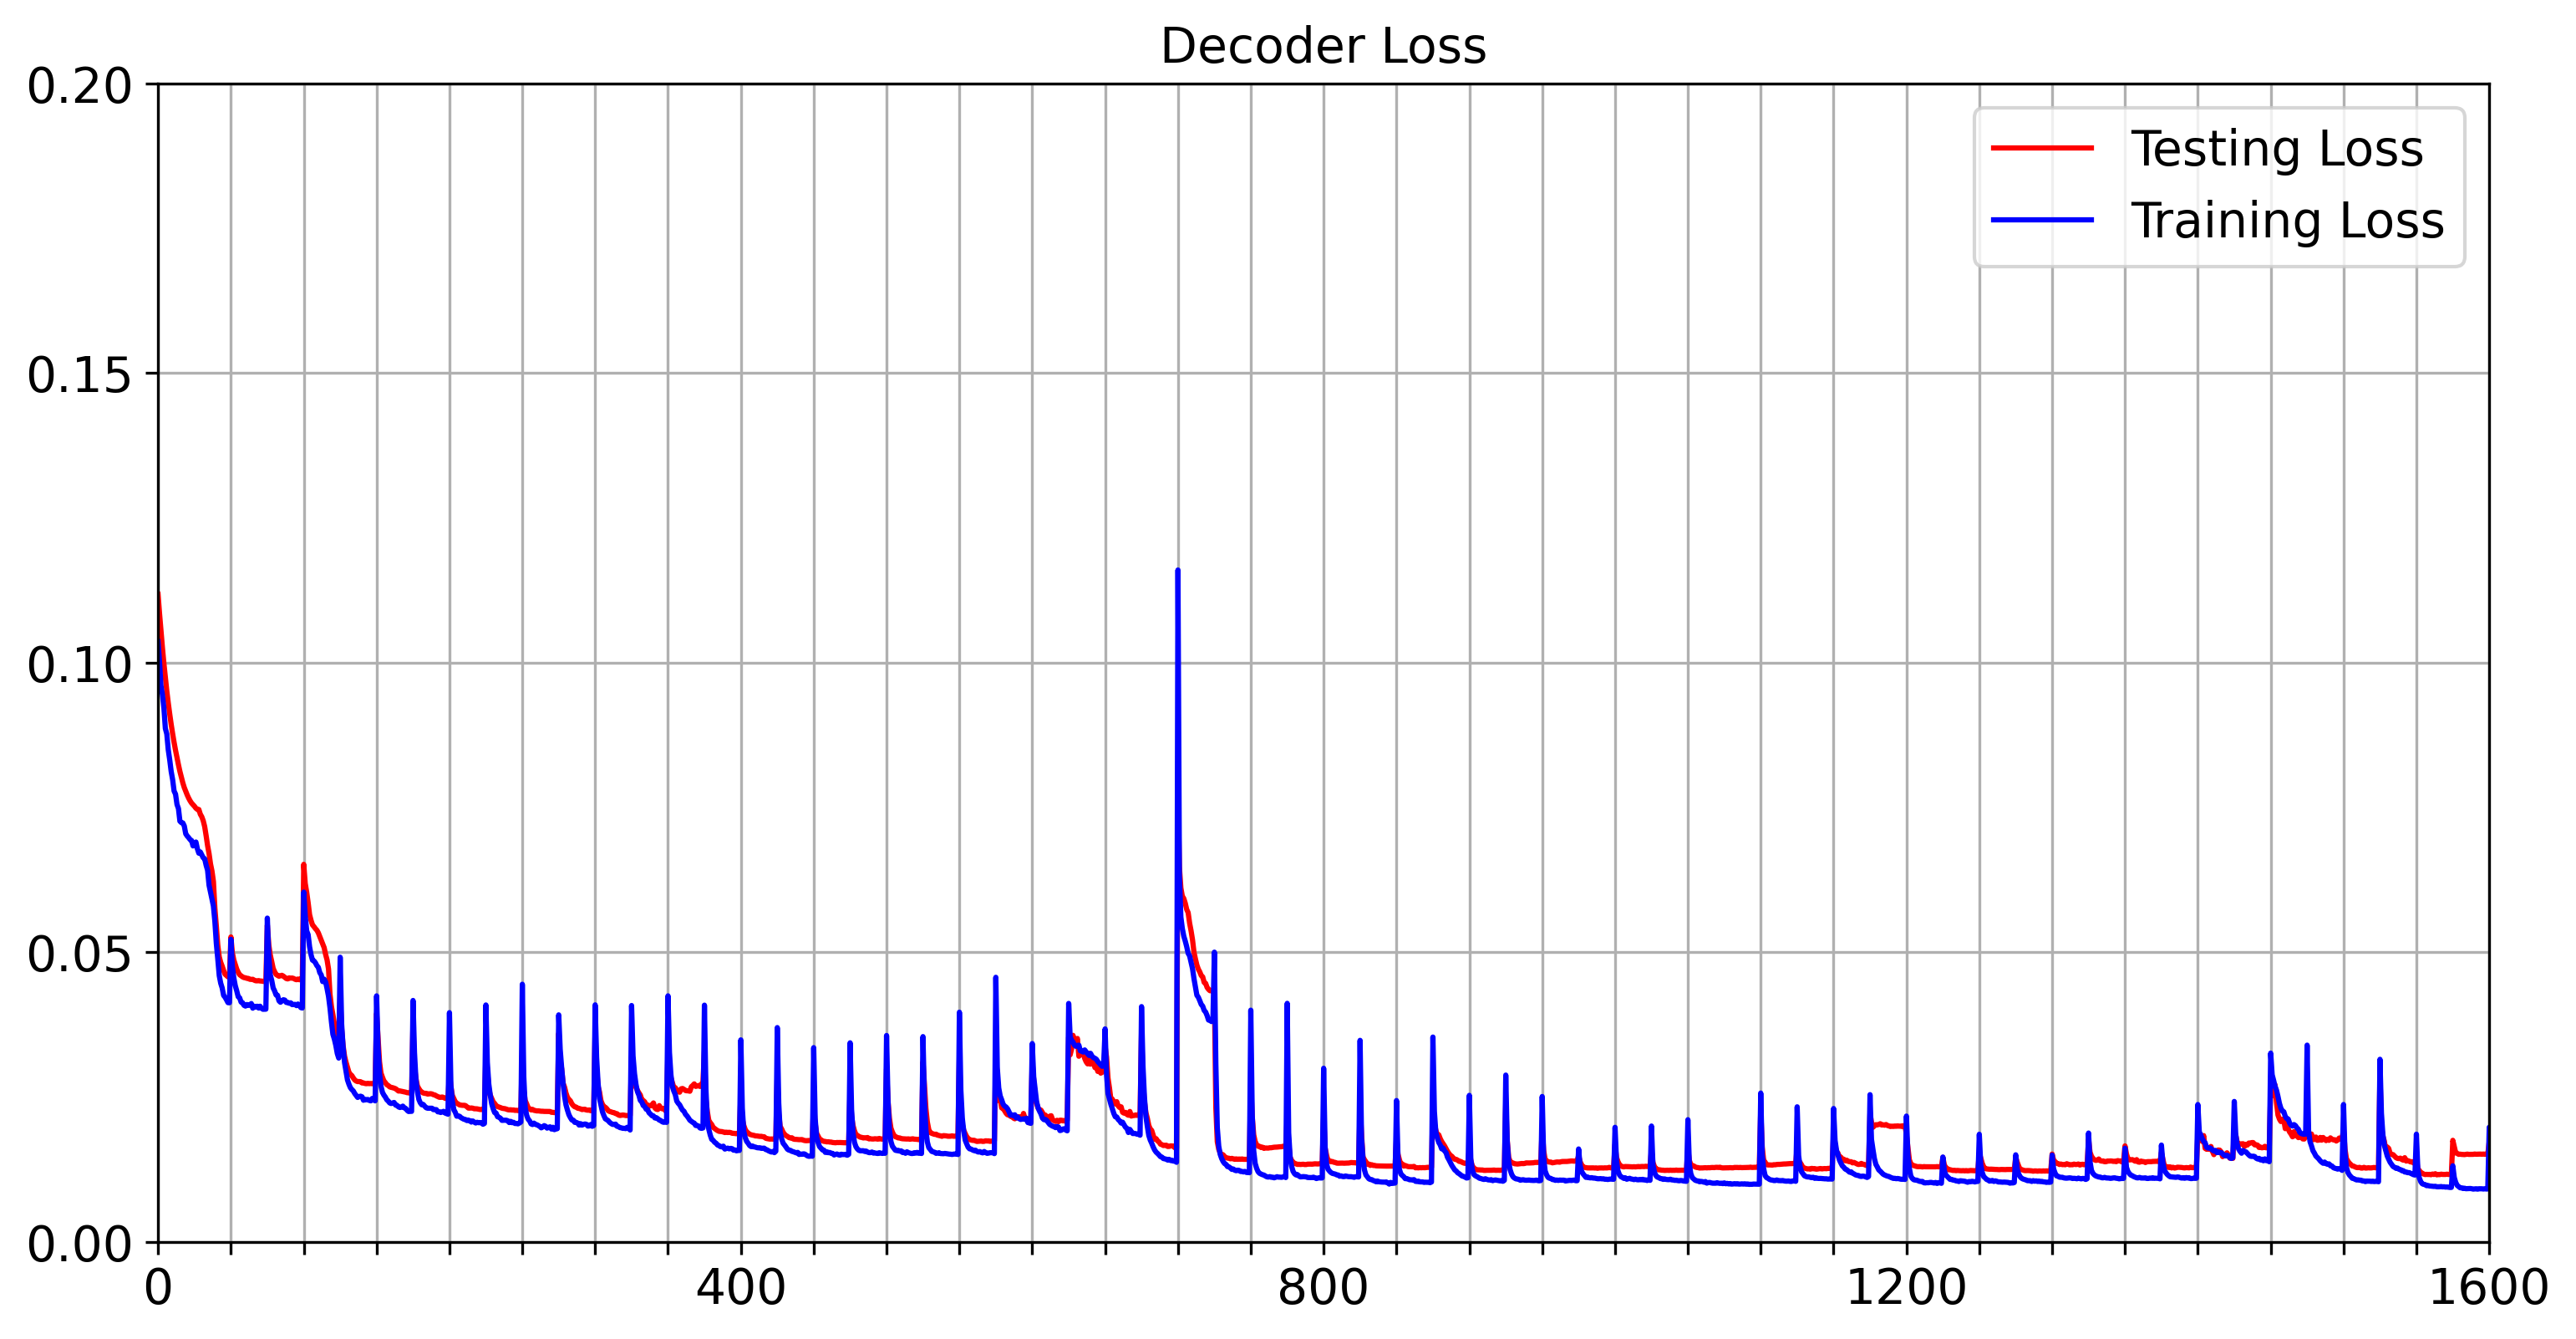

In [ ]:
device = "cuda"
batchsize = 32
learning_rate = 1e-3
loss_fn = nn.MSELoss()
model = Decoder(batchsize)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = True
# Set resume0 to False if starting from 0 epochs
# Set resume0 to True if otherwise

resume1 = False
# Set resume1 to False to continue using main directory
# Set resume1 to True to resume using snapshot directory

# Which last epoch would you like to continue?
last_epoch = 3200

# Save model and state every save_epoch
save_epoch = 5

# Continuous training directory
directory1 = f'0419_decoder_full'
# Snapshot directory (save models every save_epoch)
directory2 = f'0419_decoder_snapshot'

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

graph_loss("Decoder", save_fig=True)

Batchsize:32
last epoch: 800
Training Loss: 1.10
Testing Loss: 1.35


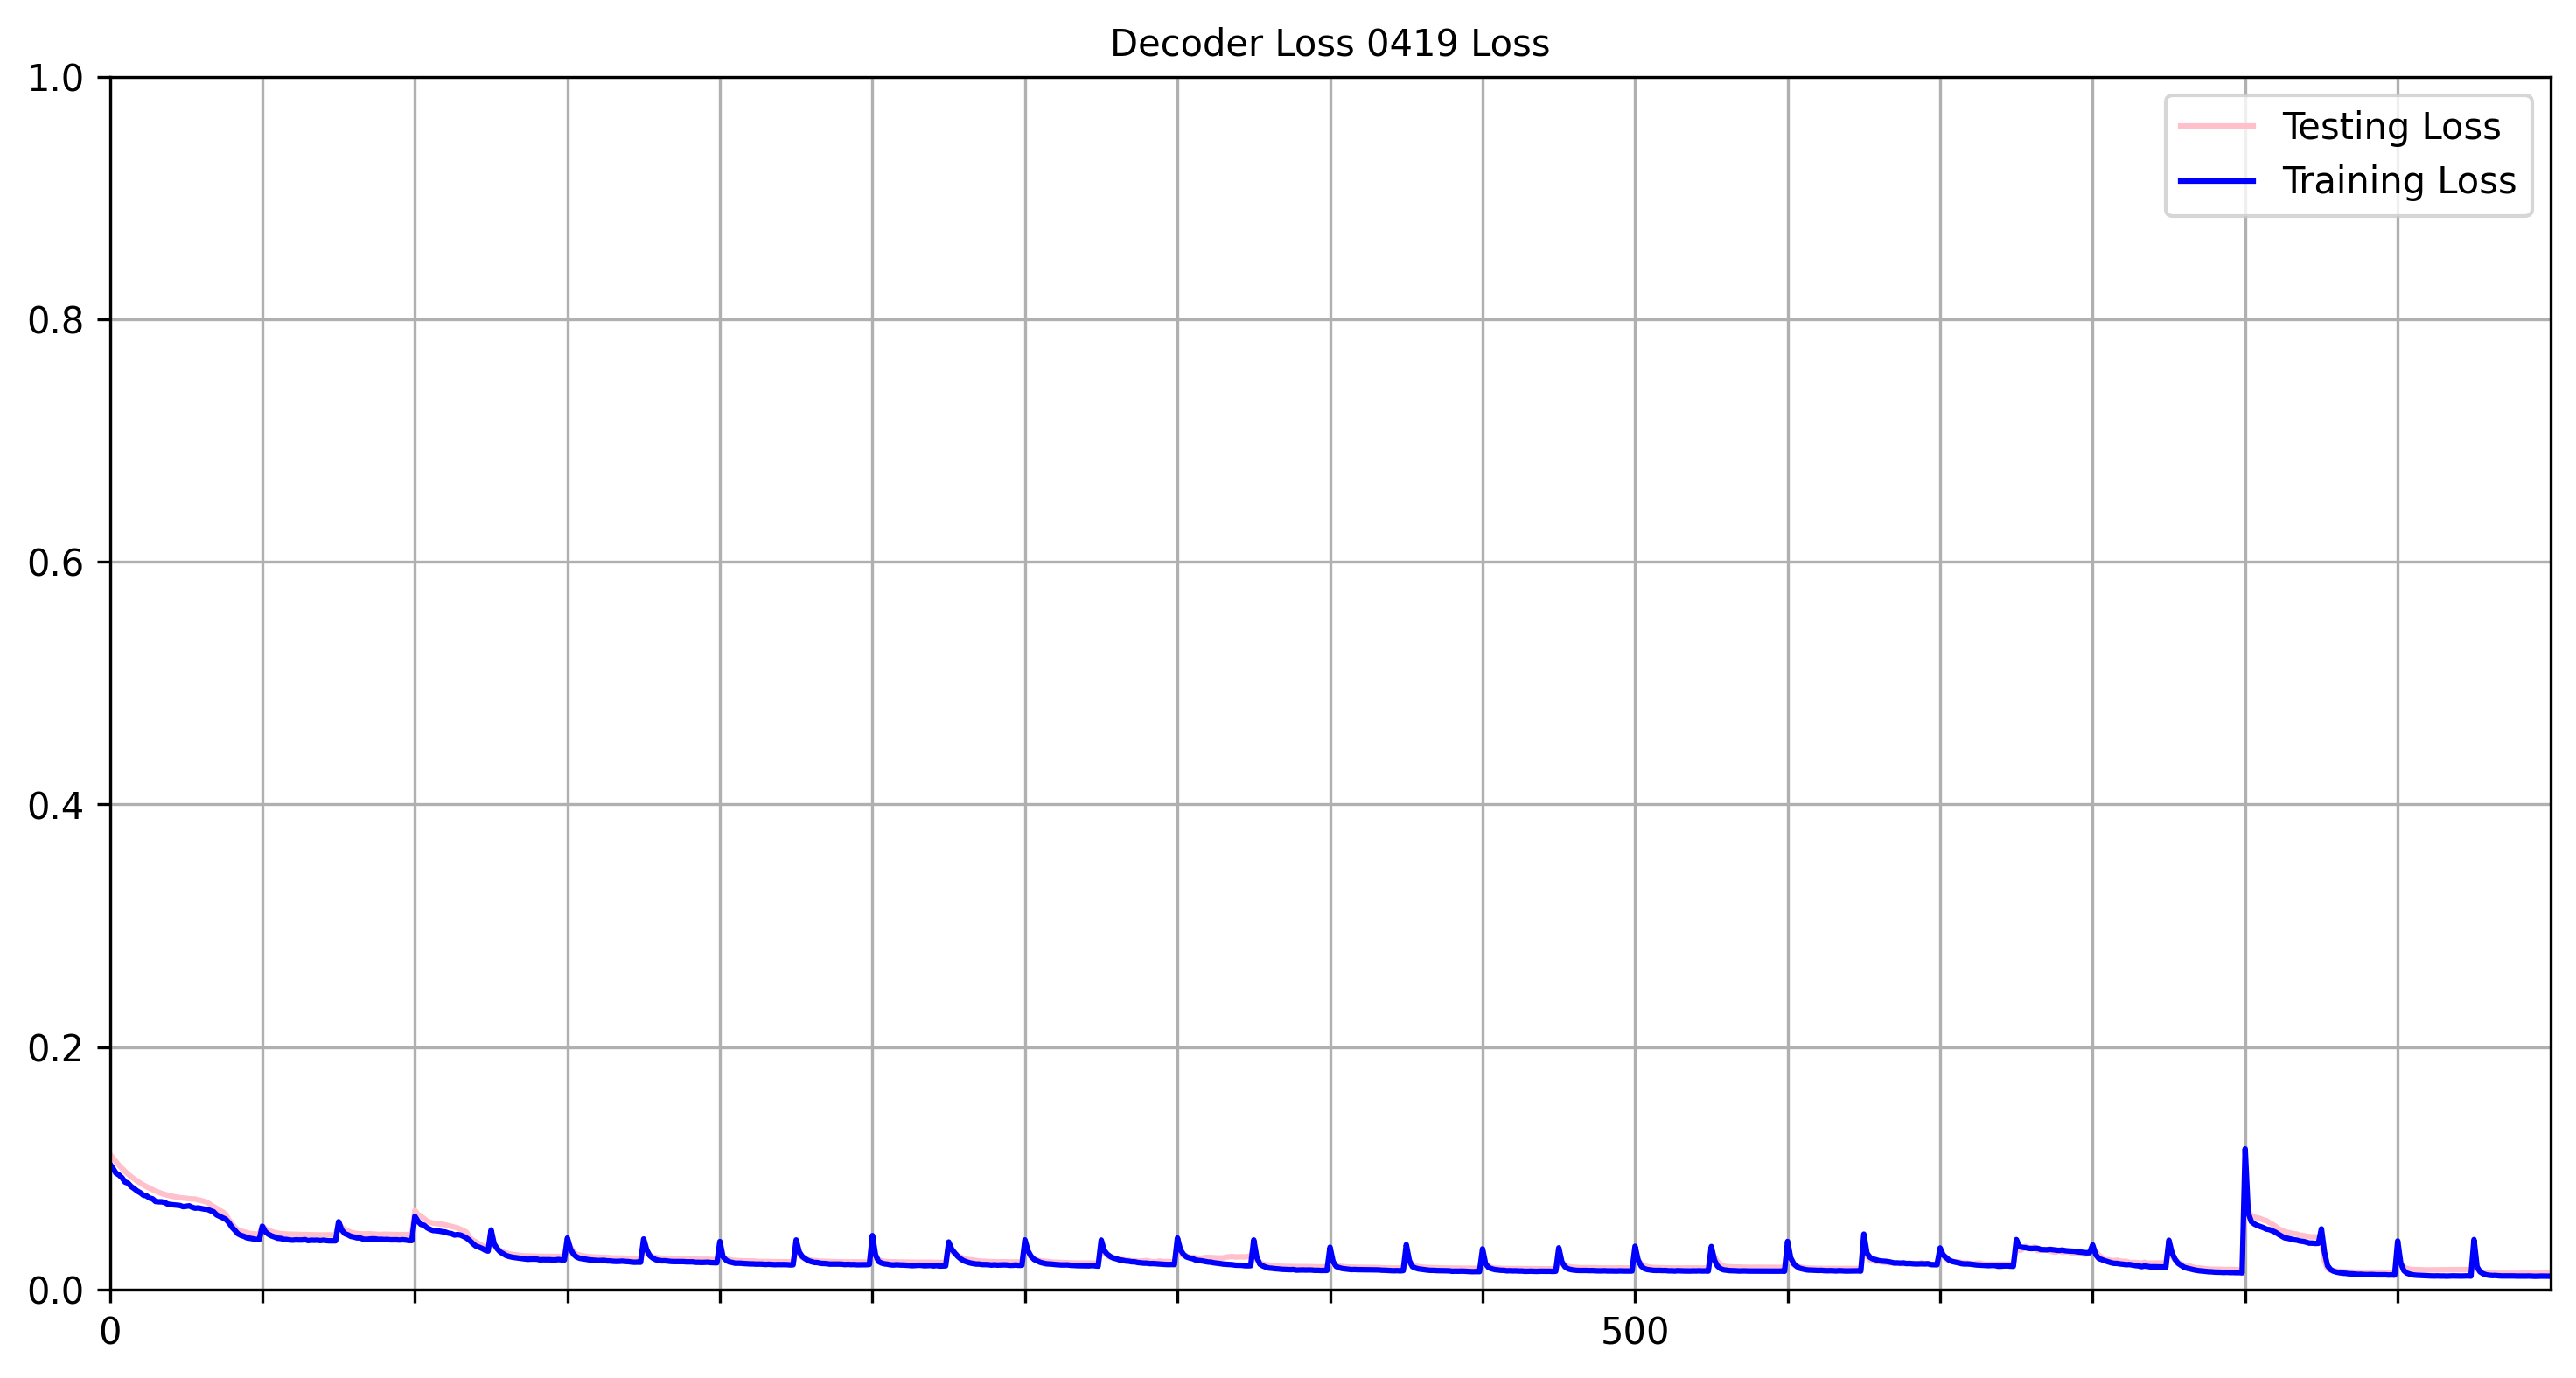

In [ ]:
graph_loss("Decoder Loss 0419", save_fig=True)

In [ ]:
def apply_decoder(apply_dataloader, model):
    model = model.to(device)

    out = directory1
    if not os.path.isdir(out):
        os.makedirs(out)

    out2 = directory2
    if not os.path.isdir(out2):
        os.makedirs(out2)

    path = f"{out}/MLP1L.pt"

    # Load the model and the optimizer of the previous run
    saved_model = torch.load(path, weights_only=True)
    model.load_state_dict(saved_model['model_state_dict'])

    frames = []

    with torch.no_grad():
        for video, watermark in apply_dataloader:
            pred = model(video)

            frames.append(pred)

    frames = torch.cat(frames)
    frames_shape = frames.shape
    frames = torch.reshape(frames, (frames_shape[0], 1, frames_shape[-2], frames_shape[-1]))

    return frames

In [ ]:
names = ["aspen", "crowd2", "ducks", "life1", "rush1", "pedestrian2", "sintel3", "sunflower1"]

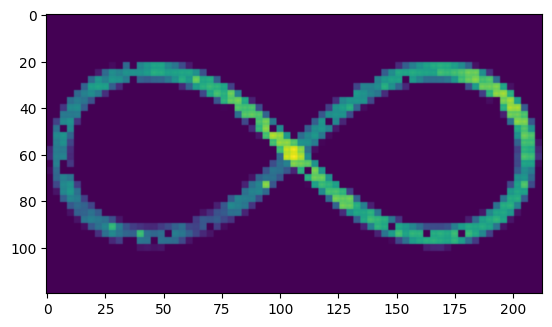

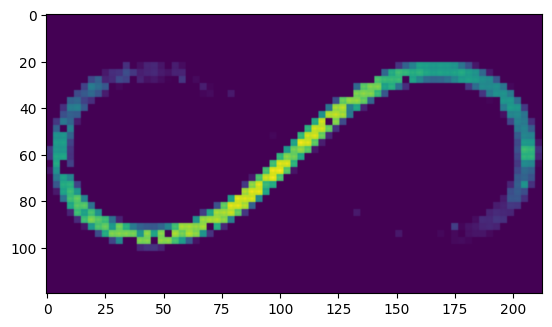

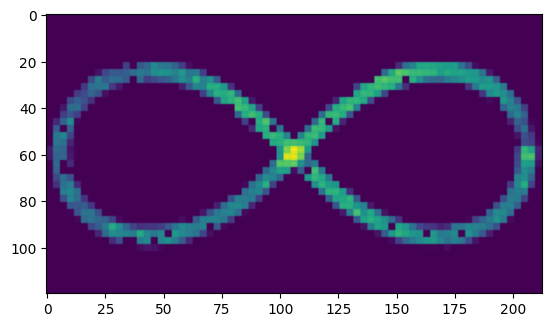

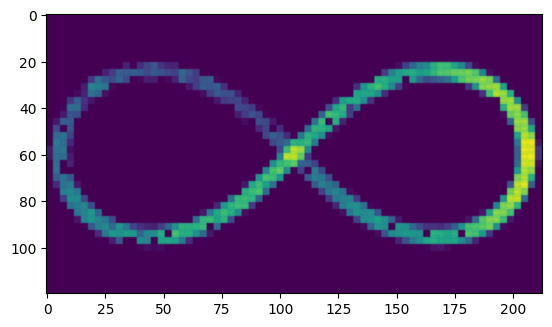

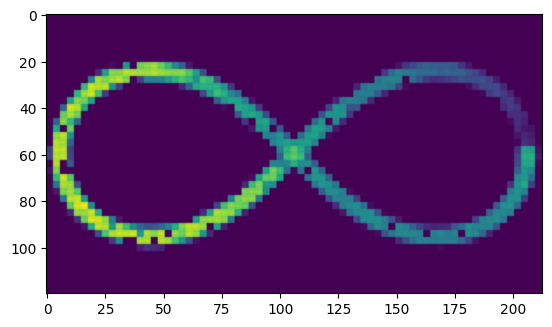

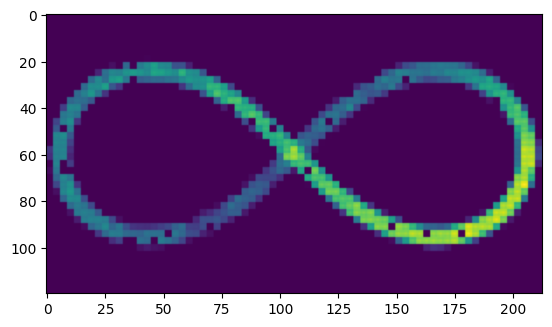

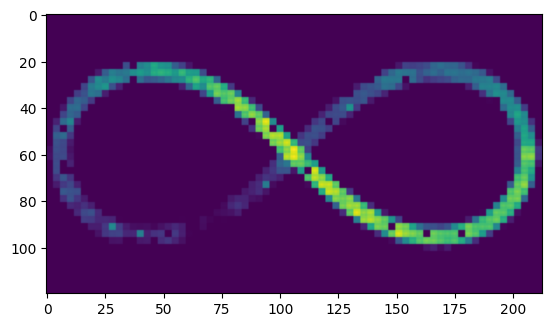

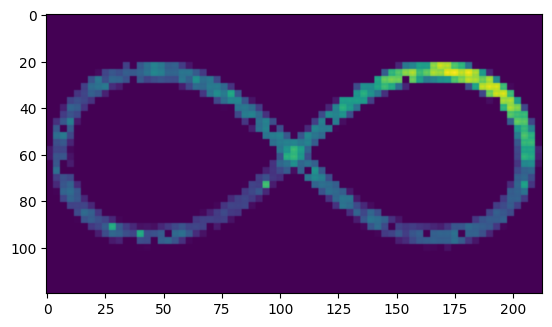

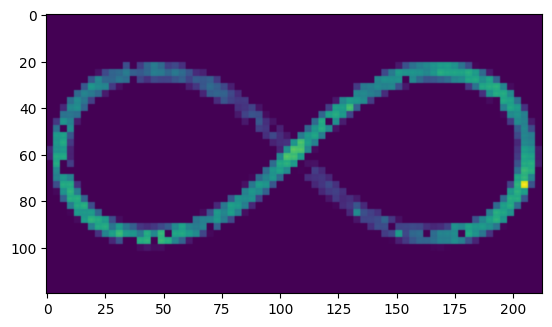

KeyboardInterrupt: 

In [ ]:
apply_watermark = wm_val
apply_watermark = apply_watermark.to(device)
batchsize = 1

for name in names:
  embedded_video = torch.load(f'{name}_embedded', weights_only=True)

  embedded_video = embedded_video.to(device)

  test_embedded_dataset = DeclareDataset(embedded_video, apply_watermark)
  test_embedded_dataloader = DataLoader(test_embedded_dataset, batch_size=batchsize, shuffle=False)

  model = Decoder()

  directory1 = f'0419_decoder_full'
  recovered_watermark = apply_decoder(test_embedded_dataloader, model)
  #torch.save(recovered_watermark.detach().cpu(), f'{name}_raw_rec_wm')
  plt.imshow(recovered_watermark.cpu()[0][0]*255)
  plt.show()
  del recovered_watermark
  #print(f'{name}_{attack} done')

  #print(f'{name} all done')

In [ ]:
names = ["ducks", "field", "ice", "life", "news", "sign", "sintel3", "waterfall"]
attacks = ["45", "90", "135", "distortion", "distortion2", "static"]

In [ ]:
apply_watermark = wm_val
apply_watermark = apply_watermark.to(device)
batchsize = 1

for name in names:
  for attack in attacks:
    embedded_video = torch.load(f'testing_embedded_tensors/{name}_{attack}', weights_only=True)
    convolved_video = torch.load(f'testing_embedded_tensors/{name}_convolved', weights_only=True)

    embedded_video = embedded_video.to(device)
    convolved_video = convolved_video.to(device)

    test_embedded_dataset = DeclareDataset(embedded_video, apply_watermark, convolved_video)
    test_embedded_dataloader = DataLoader(test_embedded_dataset, batch_size=batchsize, shuffle=False)

    model = Decoder()

    directory1 = f'0413_decoder_snapshot/epoch002030'
    recovered_watermark = apply_decoder(test_embedded_dataloader, model)
    torch.save(recovered_watermark.detach().cpu(), f'{name}_{attack}_wm_val')

    del recovered_watermark
    print(f'{name}_{attack} done')

  print(f'{name} all done')

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
recovered_watermark = torch.load('/content/drive/Shareddrives/thesis_recovered/field_135_wm_val')

In [ ]:
frame=270

In [ ]:
plt.imshow(recovered_watermark.cpu()[0][0]*255)

In [ ]:
plt.imshow(wm_val[frame][0]*255)

In [ ]:
wm_val[50][0]*255

In [ ]:
class EmbeddedDataset(Dataset):

    def __init__(self, video_frames, conv_frames):
        self.video = video_frames
        self.conv = conv_frames

    def __getitem__(self, idx):
        video = self.video[idx]
        conv = self.conv[idx]

        return video, conv

    def __len__(self):
        return len(self.video)

In [ ]:
attacked_video = add_gaussian_noise(video_tensor)
extracted_watermark = extract_watermark(attacked_video, in_hsv, model)

In [ ]:
def save_video_hsv(video_frames, input_path,output_path):
    cap = cv2.VideoCapture(original_vid_path)

    fourcc = cv2.VideoWriter_fourcc(*'x264')
    out = cv2.VideoWriter(output_path, fourcc, 60.0, (1920, 1080))

    for frame in video_frames:
        frame = (frame.numpy() * 255).astype(np.uint8)
        frame = frame.transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
        frame = cv2.cvtColor(frame, cv2.COLOR_HSV2BGR)  # Convert back to BGR
        out.write(frame)

    out.release()

In [ ]:
save_video_hsv(extracted_watermark, "Extracted_Watermark.mp4")

Model Evaluation:

In [ ]:
def get_frames(video_path, idx):
    cap = cv2.VideoCapture(video_path)
    cap.set(CV_CAP_PROP_POS_FRAMES, idx-1)
    res, frame = cap.read()

In [ ]:
def psnr(raw_vid, embedded_vid):
    i = 0
    psnr_i = 0

    while i is not 300:
        mse = np.mean((get_frames(raw_vid, i) - get_frames(embedded_vid, i) ** 2)
        if mse == 0:
            return 100
        psnr_i += (20 * np.log10(255 / np.sqrt(mse)))
        i += 1

    psnr = psnr_i/300
    return psnr

In [ ]:
def ssim(raw_vid, embedded_vid):
    i = 0
    ssim_i = (get_frames(raw_vid, i), get_frames(embedded_vid, i), data_range=255, multichannel=True)
      i += 1

    ssim = ssim_i/300
    return ssim

In [ ]:
def capacity(watermark_vid):

    while i is not 300:
      total_bits = get_frames(watermark_vid, i).size
      total_pixels = 1080 * 1920
      capacity = total_bits/total_pixels

    return capacity

In [ ]:
def ncc(raw_vid, embedded_vid):
    i = 0
    ncc_i = 0

    while i is not 300:
      ncc_i += cv2.matchTemplate(get_frames(embedded_vid, i), get_frames(raw_vid, i), cv2.TM_CCOEFF_NORMED)
      i += 1

    ncc = ncc_i/300
    return ssim

In [ ]:
def ber(watermark_vid, recovered_vid):
  # Evaluation for original watermark and recovered watermark after attacks
    i = 0
    ber_i = 0

    while i is not 300:
      watermark_bits = np.unpackbits(get_frame(watermark_vid, i).astype(np.uint8))
      recovered_bits = np.unpackbits(get_frames(recovered_vid, i).astype(np.uint8))

      # Compute BER
      bit_errors = np.sum(extracted_bits != recovered_bits)
      total_bits = len(watermark_bits)

      ber_i += bit_errors / total_bits
      i += 1

    ber = ber_i/300
    return ber

In [ ]:
#raw_vid =

In [ ]:
#watermark_vid =

In [ ]:
#embedded_vid =

In [ ]:
print(f'For ' {name} ' test sequence: ")
print(f"PSNR: {psnr(raw_vid, embedded_vid)}")
print(f"SSIM: {ssim(raw_vid, embedded_vid)}")
print(f"Capacity: {capacity(watermark_vid)}")
print(f"NCC: {ncc(raw_vid, embedded_vid)}")
print(f"BER: {ber(watermark_vid, recovered_vid)}")